In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft, ifft, fftshift, ifftshift
import sounddevice as sd
from scipy.signal import hann

### 1. Frequency modulation sound synthesis (0.5 points)

In [2]:
fs = 16000   # Sampling rate
fc = 880     # Carrier frequency
fmod = 220   # Modulation frequency
amplitude = 1
I = 2        # Modulation index
duration = 1 # number of samples in signal

#### Create the signal, plot it and also its DFT spetrum

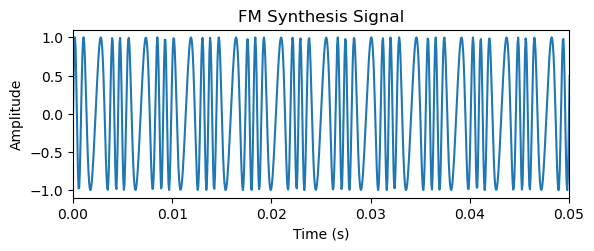

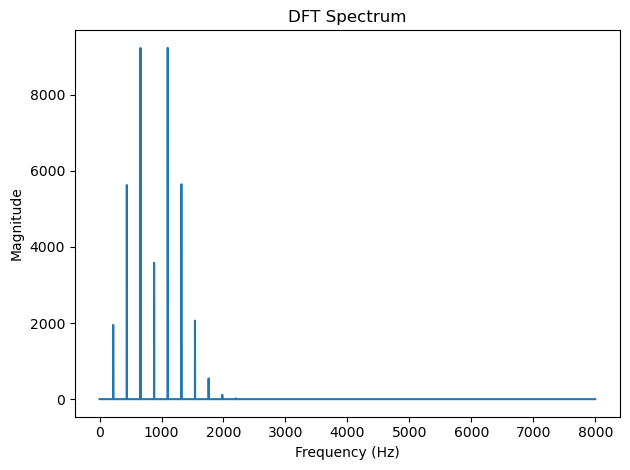

In [5]:
# The FM modulated signal
t = np.arange(0, duration, 1/fs)
carrier = 2 * np.pi * t * fc
modulator = I * np.sin(2 * np.pi * t * fmod)
waveform = amplitude * np.sin(carrier + modulator)

# Plot
plt.subplot(2, 1, 1)
plt.xlim(0, 0.05)
plt.plot(t, waveform)
plt.title('FM Synthesis Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Compute DFT and plot it
fre = np.fft.fftfreq(len(waveform), 1/fs)
spectrum = fft(waveform)
plt.figure()
plt.plot(fre[:len(fre)//2], 2*abs(spectrum)[:len(fre)//2])
plt.title('DFT Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


#### Play the sound

In [6]:
sd.play(waveform, fs)
sd.wait()

#### Auxiliary functions

In [7]:
def princarg(phase_in):
    """
    Computes principle argument,  wraps phase to (-pi, pi]
    """
    phase = np.mod(phase_in + np.pi,-2*np.pi)+np.pi;
    return phase
  

def delta_phi_(Phase_current, Phase_previous, winHopAn, wLen):
    """
    Function for calculating unwrapped phase difference between consecutive frames
    
    Phase_current: current frame phase
    Phase_previous: previous frame phase
    winHopAn: Analysis hop length
    wLen: window length
    """
    
    # nominal phase increment for the analysis hop size for each bin
    omega = 2*np.pi*(winHopAn/wLen)*np.arange(0, wLen)
    delta_phi = omega + princarg(Phase_current-Phase_previous-omega)
    
    return delta_phi

### 2. Implement a time stretching algorithm using phase vocoder. (1.5 points)

In [10]:
audioIn, fs = lb.load('audio.wav', sr=None)   # read audio

wLen = int(0.032*fs)                   # window length
winAn = np.sqrt(hann(wLen, sym=False)) # analysis window
winSyn = winAn


winHopAn = int(0.008*fs)             # Hop length or frame advance
inInd = 0                            # index for analysis
inIndSyn = 0                         # index for synthesis
R = 1.4 # winHopSyn / winHopAn;
winHopSyn = int(R * winHopAn)
difference_hop = winHopSyn - winHopAn

audioOut = np.zeros(int(1.4*len(audioIn)))      # placeholder for reconstructed audio

phi0_previous = np.zeros(wLen)  # Analysis phase 
phi_synthesis_previous = np.zeros(wLen)  # Synthesis phase 

while inInd< len(audioIn)-wLen:
    # selct the frame and multiply with window function
    frame = audioIn[inInd: inInd+wLen]* winAn 

    # compute DFT
    f = fft(frame, wLen)

    # save magnitudes and phases
    mag_f = np.abs(f)
    phi0 = np.angle(f) 

    ####################
    # processing in spectral domain 
    #######################
    if inInd == 0:
        phi0_previous = 0
        phi_synthesis_previous = 0
        
    delta_phi = delta_phi_(phi0, phi0_previous, winHopAn, wLen) 
    
    # why we need to scale delta_phi here: to keep the same phase difference between two frames
    # and keep the frequency unchanged, otherwise would lead to phase mismatch
    # when we change the hop length in synthesis signal 
    phi_synthesis = phi_synthesis_previous + (winHopSyn / winHopAn) * delta_phi
    phi_synthesis = princarg(phi_synthesis)
    
    # Recover the complex FFT back
    ft = (abs(f)* np.exp(1j*phi_synthesis)) 

    # inverse DFT and windowing
    frame = np.real(ifft(ft))*winSyn
    phi0_previous = phi0
    phi_synthesis_previous = phi_synthesis
    
    # Ovelap add
    inIndSyn = inIndSyn + winHopSyn
    audioOut[inIndSyn :inIndSyn +wLen] =  audioOut[inIndSyn :inIndSyn +wLen] + frame
    
    # frame advance by winHopSyn
    inInd = inInd + winHopAn

C:\Users\Phan Phuong Uyen\AppData\Local\Temp\ipykernel_23604\3032735554.py:4: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  winAn = np.sqrt(hann(wLen, sym=False)) # analysis window


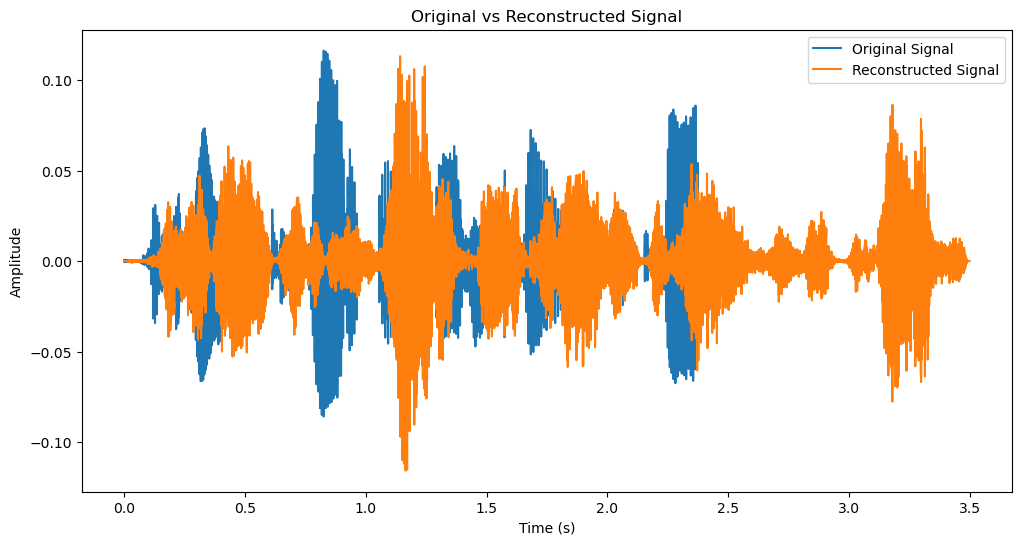

In [9]:
sd.play(audioOut, fs)
signal_length = len(audioOut)
# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(audioIn)) / fs, audioIn, label='Original Signal')
plt.plot(np.arange(len(audioOut)) / fs, audioOut, label='Reconstructed Signal')
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Bonus question: Add pitch shifting

In [77]:
# To pitch shift the time-stretched signal, need to speed up the output audio 
def speedx(audio, factor):
    """ Multiplies the sound's speed by some `factor` """
    indices = np.round( np.arange(0, len(audio), factor))
    indices = indices[indices < len(audio)].astype(int)
    return audio[indices.astype(int)]

# change the pitch of the tone by 5 semitone
factor = 2**(1.0 * 25 / 12.0)

speedx(audioOut, factor)
print(len(audioOut))

56000


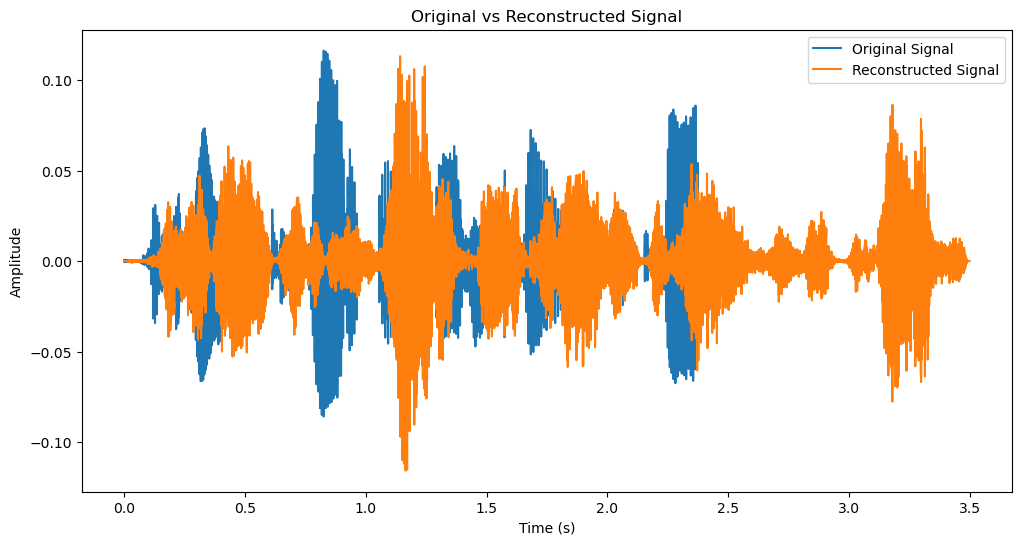

In [78]:
sd.play(audioOut, fs)
signal_length = len(audioOut)
# Plot the original and reconstructed signals
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(audioIn)) / fs, audioIn, label='Original Signal')
plt.plot(np.arange(len(audioOut)) / fs, audioOut, label='Reconstructed Signal')
plt.title('Original vs Reconstructed Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()